# 基本設定

## 引用模組

In [1]:
from PIL import Image
from torch.utils.data import (
    DataLoader,
    Dataset,
)  # Gives easier dataset managment and creates mini batches

import numpy as np  # linear algebra
import os
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F  # All functions that don't have any parameters
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler
import torchvision
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset

## 連接 google drive

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

Mounted at /content/drive


## 解壓縮訓練集

In [ ]:
# import zipfile

# with zipfile.ZipFile('/content/drive/MyDrive/dog-and-cat.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/CNN/dog-and-cat')

## 選擇 device
優先使用 GPU，後續輸入資料及 Model 權重需要在同一個運算單元計算

In [4]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = "cpu"
print("Device: ", device)

Device:  cpu


## 自定義 Dataset

繼承 PyTorch 的 Dataset，覆蓋 __init__、__len__、__getitem__

In [2]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(
            dataset
        )  # some images are CMYK, Grayscale, check only RGB
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory

    # 非 RGB 圖片會被忽略
    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if Image.open(dataset[index][0]).getbands() == (
                "R",
                "G",
                "B",
            ):  # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB

## 資料增強

In [4]:
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),  # 隨機裁剪並縮放到指定大小
        transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
        transforms.RandomRotation(10),  # 隨機旋轉，範圍為[-10, 10]度
        transforms.ToTensor(),  # 將 PIL Image 或 ndarray 轉換為 tensor
        transforms.Normalize([0.5] * 3, [0.5] * 3),  # 歸一化
    ]
) # train transform

valid_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
) # valid transform

## 載入訓練集

In [5]:
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

dataset = ImageFolder("./dog-and-cat/dog-and-cat/training_set")

# 將訓練資料再切分為 Train、Validation
train_data, valid_data, train_label, valid_label = train_test_split(
    dataset.imgs, dataset.targets, test_size=0.2, random_state=42
)

valid_dataset = ImageLoader(valid_data, valid_transform)
train_dataset = ImageLoader(train_data, train_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

# 分類模型

In [ ]:
from nn.generation_4.generation_4 import CatDogClassifier

# 載入貓狗分類模型
model = CatDogClassifier()
model.to(device)

# print(model.parameters)

# 超參數

In [32]:
# 選擇優化器跟loss函數
LR = 0.0001
# LR = 0.00005 20
# LR = 0.000001 20
# LR = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

WEIGHT_DECAY = 0.01  # L2 正則化參數
# optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # 增加權重衰減參數來實現 L2 正則化

criterion = nn.CrossEntropyLoss()

# 載入之前的參數

In [29]:
# checkpoint = torch.load(f"./nn/generation_3/checpoint_epoch_best_92.pt", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# 圖表

[] []


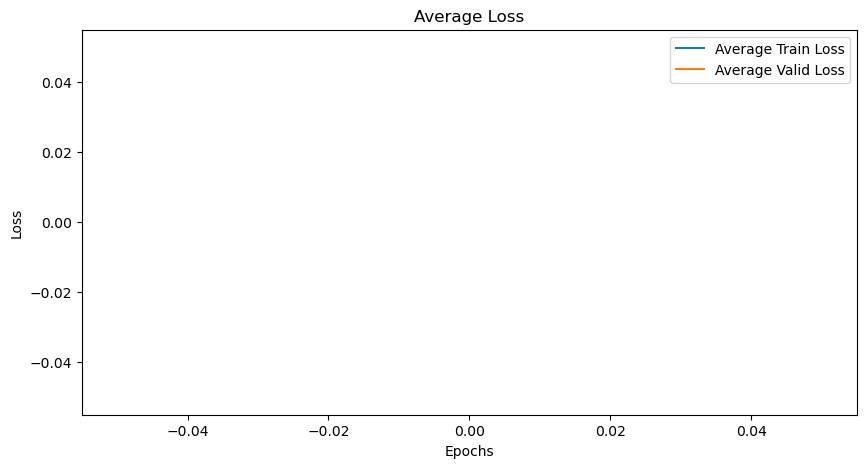

In [45]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

average_train_losses = []
average_valid_losses = []

# 繪製平均損失
plt.figure(figsize=(10,5))
plt.title("Average Loss")
plt.plot(average_train_losses, label="Average Train Loss")
plt.plot(average_valid_losses, label="Average Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 訓練

In [40]:
best = 0

[0.010266667675182717] [0.010241117721643394]


Average Loss:  0.0041717415260177785   Accuracy:  1445  /  1601    90 %


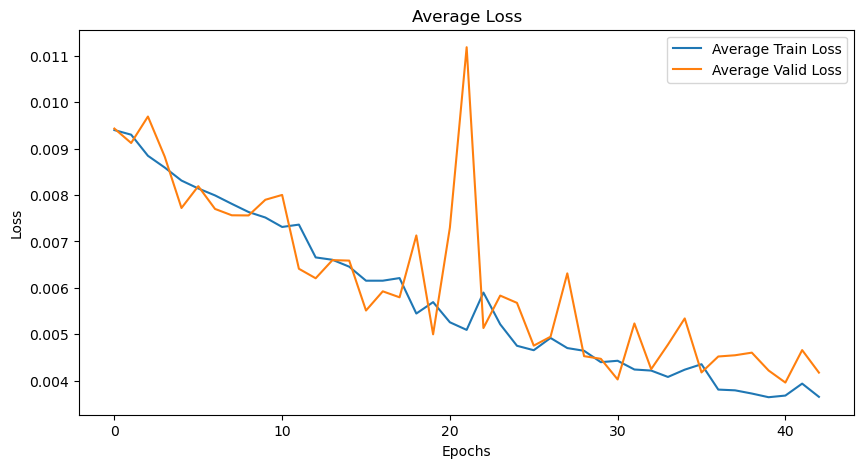

Epoch:  6
Progress: 34%

KeyboardInterrupt: 

In [61]:
EPOCH = 30

for epoch in range(0, EPOCH):
    print("Epoch: ", epoch)

    # 訓練階段
    model.train()

    train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device=device)
        target = target.to(device=device)

        output = model(data)
        loss = criterion(output, target)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print("\rProgress: %d%%" % batch_idx, end="")

    train_loss /= len(train_loader.dataset)
    average_train_losses.append(train_loss)

    # 驗證階段
    model.eval()

    valid_loss = 0
    valid_correct = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            _, predictions = torch.max(output, 1)

            valid_correct += (predictions == target).sum().item()
            valid_loss += criterion(output, target).item()

        valid_loss /= len(valid_loader.dataset)
        average_valid_losses.append(valid_loss)

    # 在每個 epoch 結束時，清除當前的圖表並重新繪製
    clear_output(wait=True)

    print(
        "Average Loss: ",
        valid_loss,
        "  Accuracy: ",
        valid_correct,
        " / ",
        len(valid_loader.dataset),
        "  ",
        int(valid_correct / len(valid_loader.dataset) * 100),
        "%",
    )

    plt.figure(figsize=(10, 5))
    plt.title("Average Loss")
    plt.plot(average_train_losses, label="Average Train Loss")
    plt.plot(average_valid_losses, label="Average Valid Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # if valid_correct > best:
    #     best = valid_correct
    #     # save model
    #     torch.save(
    #         {
    #             "model_state_dict": model.state_dict(),
    #             "optimizer_state_dict": optimizer.state_dict(),
    #         },
    #         f"/content/drive/MyDrive/checpoint_epoch_best.pt",
    #     )

# 測試集驗證模型準確率

## 測試集資料讀取

In [50]:
test_dataset = ImageFolder(
    "./dog-and-cat/test_set/",
    transform=valid_transform,
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## 測試

In [54]:
# 進入評估模式（evaluation mode）
# 所有的 dropout 和 batch normalization 層都會被設定為評估模式。
# 在這種模式下，dropout 層不會丟棄任何單位，而 batch normalization 層則會使用整個訓練集的統計值，而不是批次的統計值。
model.eval()

test_loss = 0
correct = 0

# 上下文管理器，用於暫時禁止梯度計算。
# 在這個上下文管理器下，所有的計算都不會追蹤梯度。
# 這是因為在評估模型的時候，我們不需要計算梯度，也不會進行反向傳播。這能夠節省大量的記憶體。
with torch.no_grad():
    for data, target in test_dataloader:
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        _, predictions = torch.max(output, 1)

        correct += (predictions == target).sum().item()
        test_loss += criterion(output, target)

    test_loss /= len(test_dataloader.dataset)

    print(
        "Average Loss: ",
        test_loss,
        "  Accuracy: ",
        correct,
        " / ",
        len(test_dataloader.dataset),
        "  ",
        int(correct / len(test_dataloader.dataset) * 100),
        "%",
    )

Average Loss:  tensor(0.4108)   Accuracy:  1678  /  2023    82 %


In [52]:
torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        f"./checpoint_epoch_best.pt",
    )